In [721]:
#imports
import json
import numpy as np
import pandas as pd
import parse_data.prepare_data as prepare_data
import parse_data.flip_rotate_trajectories as flip_rotate_trajectories
import data_extraction.get_indices as get_indices
import plotting.plot_trajectory as plot_trajectory
import trajectory_analysis.trajectory_vectors as trajectory_vectors
import trajectory_analysis.trajectory_headangle as trajectory_headangle
import plotting.plot_octagon as plot_octagon
import data_extraction.extract_trial as extract_trial
import globals
import scipy
import math
from parse_data import preprocess
import flip_rotate_headangle_functions
import headangle_bin_assignment
import headangle_analysis_plotting_functions

In [722]:
data_folder = '/Users/benny/Desktop/MSc/Project/Git/repos/octagon_analysis'
json_filename = ['Json_data/2024-09-13_11-31-00_YansuJerrySocial.json']

json_filenames_all_social = [r'Json_data/2024-09-13_11-31-00_YansuJerrySocial.json',
                             r'Json_data/2024-09-27_14-25-20_SaraEmilySocial.json',
                             r'Json_data/2024-10-17_14-28-40_ShamirAbigailSocial.json',
                             r'Json_data/2024-10-17_16-41-38_ZimoElsaSocial.json',
                             r'Json_data/2024-11-12_13-31-14_KhadijaWendySocial.json']

In [723]:
dfs, trial_lists = prepare_data.prepare_data(data_folder, json_filename, combine=False)

filepath: /Users/benny/Desktop/MSc/Project/Git/repos/octagon_analysis/Json_data/2024-09-13_11-31-00_YansuJerrySocial.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.


In [724]:
trial_list = trial_lists[0]
len(trial_list)

129

In [725]:
#check bin ranges
bin_ranges = define_45_degree_bins()

for idx, (start, end) in enumerate(bin_ranges):
    print(f"Bin {idx + 1}: {np.degrees(start):.2f}° to {np.degrees(end):.2f}°")


Bin 1: 337.50° to 22.50°
Bin 2: 22.50° to 67.50°
Bin 3: 67.50° to 112.50°
Bin 4: 112.50° to 157.50°
Bin 5: 157.50° to 202.50°
Bin 6: 202.50° to 247.50°
Bin 7: 247.50° to 292.50°
Bin 8: 292.50° to 337.50°


In [726]:
#filter for trials 

#High-Low
trial_list_indices = get_indices.get_trials_trialtype(trial_list, trial_type=globals.HIGH_LOW)
trial_list_HL = [trial_list[i] for i in trial_list_indices]

#45° wall separation
single_wall_sep_trial_indices = get_indices.get_trials_with_wall_sep(trial_list_HL, wall_sep=1)
trial_list_45_HL = [trial_list_HL[i] for i in single_wall_sep_trial_indices]

#player 0 wins
player0_win_indices = get_indices.get_player_win_indices(trial_list_45_HL, player_id=0)
trial_list_0_45_HL = [trial_list_45_HL[i] for i in player0_win_indices]
print(len(trial_list_0_45_HL))

#player 1 wins
player1_win_indices = get_indices.get_player_win_indices(trial_list_45_HL, player_id=1)
trial_list_1_45_HL = [trial_list_45_HL[i] for i in player1_win_indices]
print(len(trial_list_1_45_HL))

16
19


In [727]:
#example trial

#find theta
theta = flip_rotate_trajectories.find_rotation_angle_trial(trial_list=trial_list_1_45_HL, trial_index=3)

#find altered yaws
altered_yaw_values = flip_rotate_trial_headangles(trial_list=trial_list_1_45_HL, trial_index=3, player_id=1, theta=theta)

#define trial
trial=trial_list_1_45_HL[3]

In [680]:
#take the new yaw values for example player in example trial
player_altered_yaw = np.array(altered_yaw_values[1])

#create a copy of the trial with the new yaw values
trial_copy = replace_with_altered_yaws(trial_list=trial_list_1_45_HL, trial_index=3, altered_yaw_values=player_altered_yaw, player_id=1)

#define time stamps for trial copy
slice_onset = trial_copy[trial_copy['eventDescription'] == globals.SLICE_ONSET]
slice_onset_index = slice_onset.index[0] - trial_copy.index[0]
selected_trigger_activation = trial_copy[trial_copy['eventDescription'] == globals.SELECTED_TRIGGER_ACTIVATION]
selected_trigger_activation_index = selected_trigger_activation.index[0] - trial_copy.index[0]


In [681]:
#checking head angles have changes

#head angles in original trial
original_headangles_dg = trial[globals.PLAYER_ROT_DICT[1]['yrot']].iloc[slice_onset_index:selected_trigger_activation_index]
print(original_headangles_dg)
#in radians
original_headangles = trajectory_vectors.extract_trial_player_headangles(trial=trial, player_id=1)
print(original_headangles)


#head angles in trial copy
headangles = trial_copy[globals.PLAYER_ROT_DICT[1]['yrot']].iloc[slice_onset_index:selected_trigger_activation_index]
print(headangles)
print(np.deg2rad(headangles))

24264     42.553680420
24265     42.553680420
24266     42.673961639
24267     43.108913422
24268     43.558643341
             ...      
24479    118.945289612
24480    118.985870361
24481    119.038803101
24482    119.081451416
24483    119.115821838
Name: data.playerPosition.1.rotation.y, Length: 220, dtype: float64
24264    0.742701832
24265    0.742701832
24266    0.744801135
24267    0.752392476
24268    0.760241744
            ...     
24479    2.075986933
24480    2.076695201
24481    2.077619052
24482    2.078363405
24483    2.078963282
Name: data.playerPosition.1.rotation.y, Length: 220, dtype: float64
24264    267.553680420
24265    267.553680420
24266    267.673961639
24267    268.108913422
24268    268.558643341
             ...      
24479    343.945289612
24480    343.985870361
24481    344.038803101
24482    344.081451416
24483    344.115821838
Name: data.playerPosition.1.rotation.y, Length: 220, dtype: float64
24264    4.669692649
24265    4.669692649
24266    4.671791

In [682]:
#flip and rotate trajectory for example trial

#obtain altered coordinates
altered_coords = flip_rotate_trajectories.flip_rotate_trial(trial_list=trial_list_1_45_HL, trial_index=3, theta=theta, flip=True)
altered_coords = np.array(altered_coords)

#replace old coordinates with new ones in new trial copy
trial_copy_coords = flip_rotate_trajectories.replace_with_altered_coordinates(trial_list=trial_list_1_45_HL, trial_index=3, altered_coordinates=altered_coords)

In [683]:
#checking trajectory has changed

#trajectory in original trial copy
original_trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial_copy, player_id=1)
print(original_trajectory)

#trajectory in new trial 
updated_trajectory= trajectory_vectors.extract_trial_player_trajectory(trial=trial_copy_coords, player_id=1)
print(updated_trajectory)

[[-4.32443047e+00 -4.32443047e+00 -4.43299437e+00 -4.55499506e+00
  -4.66274357e+00 -4.76655006e+00 -4.86502409e+00 -4.94100046e+00
  -4.99617338e+00 -5.00800085e+00 -5.01749802e+00 -4.98328400e+00
  -4.94018555e+00 -4.87755394e+00 -4.78342724e+00 -4.68335533e+00
  -4.59186935e+00 -4.48773050e+00 -4.37434196e+00 -4.25453520e+00
  -4.12728500e+00 -4.01096487e+00 -3.88582754e+00 -3.74412513e+00
  -3.61794686e+00 -3.46751189e+00 -3.34631777e+00 -3.19987130e+00
  -3.06438422e+00 -2.92389941e+00 -2.77698565e+00 -2.62949991e+00
  -2.48548532e+00 -2.32055116e+00 -2.18759227e+00 -2.03031945e+00
  -1.88588881e+00 -1.72354352e+00 -1.56717539e+00 -1.42320657e+00
  -1.27493238e+00 -1.12094247e+00 -9.81309116e-01 -8.15585971e-01
  -6.42441511e-01 -4.85150129e-01 -3.09927791e-01 -1.46078557e-01
   2.65569035e-02  2.10836843e-01  4.03544217e-01  6.01884961e-01
   7.98937142e-01  9.74401891e-01  1.18230438e+00  1.37290800e+00
   1.56781888e+00  1.75803626e+00  1.92624366e+00  2.09706569e+00
   2.25059

In [684]:
#combine new coordinates and new head angles in a single trial copy
trial_example = trial_copy
for i in range(len(altered_coords)):
        trial_example[globals.PLAYER_LOC_DICT[i]['xloc']] = altered_coords[i][0] # x coordinates
        trial_example[globals.PLAYER_LOC_DICT[i]['yloc']] = altered_coords[i][1] # y coordinates

#check that both coordinates and head angles are updated in trial example
example_trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial_example, player_id=1)
print(example_trajectory)

example_headangles = trajectory_vectors.extract_trial_player_headangles(trial=trial_example, player_id=1)
print(example_headangles)


[[ 3.23341112e+00  3.23341112e+00  3.40263492e+00  3.60323713e+00
   3.78561244e+00  3.96985356e+00  4.15995877e+00  4.32014191e+00
   4.46181551e+00  4.57119999e+00  4.65903115e+00  4.71712005e+00
   4.75671642e+00  4.77566556e+00  4.76358526e+00  4.73517584e+00
   4.70391417e+00  4.65091889e+00  4.57877613e+00  4.49016306e+00
   4.38105077e+00  4.27620829e+00  4.14886302e+00  3.98997438e+00
   3.84534359e+00  3.66134688e+00  3.51311473e+00  3.32617146e+00
   3.15136277e+00  2.96720338e+00  2.77222101e+00  2.57492445e+00
   2.38123001e+00  2.15783431e+00  1.97774761e+00  1.76379019e+00
   1.56722609e+00  1.34625354e+00  1.13359143e+00  9.37934086e-01
   7.36648171e-01  5.27962234e-01  3.38857290e-01  1.19548777e-01
  -1.02438421e-01 -3.01628621e-01 -5.13124668e-01 -7.05457006e-01
  -8.99689847e-01 -1.09611660e+00 -1.29094661e+00 -1.48146653e+00
  -1.66043431e+00 -1.81604343e+00 -1.98085215e+00 -2.12494017e+00
  -2.26121374e+00 -2.37369095e+00 -2.46555498e+00 -2.52378793e+00
  -2.55904

In [685]:
#sort new head angles into bin for example trial

bin_index = sort_head_angle_into_bin(example_trajectory, example_headangles, debug=False)
bin_index = np.array(bin_index)
print(bin_index)
print(f"Head angle at slice onset falls into Bin {int(bin_index[0])}")

[7]
Head angle at slice onset falls into Bin 7


In [686]:
#sort head angles into bin for original trial

bin_index = sort_head_angle_into_bin(original_trajectory, original_headangles, debug=False)
bin_index = np.array(bin_index)
print(bin_index)
print(f"Head angle at slice onset falls into Bin {int(bin_index[0])}")


[2]
Head angle at slice onset falls into Bin 2


In [687]:
#sort head angles into bins for all original trials

print(trial[globals.PLAYER_ROT_DICT[0]['yrot']].iloc[slice_onset_index:selected_trigger_activation_index])
bin_assignments_og = assign_bins_to_all_trials(trial_list=trial_list_1_45_HL, player_id=1, debug=False)

#print output
for idx, bin_index in enumerate(bin_assignments_og):
    print(f"Trial {idx}: Bin {bin_index}")

24264    245.884094238
24265    245.884094238
24266    245.884094238
24267    245.884094238
24268    245.884094238
             ...      
24479    236.059326172
24480    236.059326172
24481    236.059326172
24482    236.059326172
24483    236.059326172
Name: data.playerPosition.0.rotation.y, Length: 220, dtype: float64
Trajectory: [[ 7.97480249e+00  7.95316935e+00  7.87355471e+00  7.79890108e+00
   7.69694710e+00  7.59994888e+00  7.49513769e+00  7.38214111e+00
   7.26562262e+00  7.14976549e+00  7.02081013e+00  6.90094995e+00
   6.75107431e+00  6.61264372e+00  6.46942091e+00  6.32145262e+00
   6.20244360e+00  6.07479334e+00  5.95695305e+00  5.85524559e+00
   5.76084566e+00  5.68250418e+00  5.61835670e+00  5.57038593e+00
   5.53442001e+00  5.51025200e+00  5.49833727e+00  5.49698973e+00
   5.50462294e+00  5.52534294e+00  5.54857302e+00  5.59319401e+00
   5.63983202e+00  5.69664001e+00  5.76563501e+00  5.84250116e+00
   5.92395115e+00  6.00467062e+00  6.09681749e+00  6.21804714e+00
   6.33

In [694]:
#create new trial list containing trials with updated yaws and coordinates

updated_trial_list1 = process_and_update_trials(trial_list_1_45_HL, 1)

#checks
len(updated_trial_list1)
print(trajectory_vectors.extract_trial_player_headangles(trial=updated_trial_list[3], player_id=1))

13595    0.285440901
13596    0.279314033
13597    0.263371269
13598    0.250522116
13599    0.240168228
            ...     
13706    5.714654743
13707    5.714480572
13708    5.714096544
13709    5.713677363
13710    5.713222495
Name: data.playerPosition.1.rotation.y, Length: 116, dtype: float64


In [695]:
#create new trial list containing trials with updated yaws and coordinates for other player

updated_trial_list0 = process_and_update_trials(trial_list_0_45_HL, 0)

#checks
len(updated_trial_list0)
print(trajectory_vectors.extract_trial_player_headangles(trial=updated_trial_list[3], player_id=0))

13595    0.680687463
13596    0.680687463
13597    0.666747413
13598    0.608566930
13599    0.509177226
            ...     
13706    5.814015153
13707    5.812197279
13708    5.808560999
13709    5.806136457
13710    5.804318051
Name: data.playerPosition.0.rotation.y, Length: 116, dtype: float64


In [699]:
#sort head angle into bin for all updated trials

bin_assignments0 = assign_bins_to_all_trials(trial_list=updated_trial_list0, player_id=0)
for idx, bin_index in enumerate(bin_assignments1):
    print(f"Trial {idx}: Bin {bin_index}")
print(type(bin_assignments1[0]))

bin_assignments1 = assign_bins_to_all_trials(trial_list=updated_trial_list1, player_id=1)


Trajectory: [[ 6.68112011e+00  6.68112011e+00  6.68112011e+00  6.68112011e+00
   6.68112011e+00  6.68112011e+00  6.68112011e+00  6.68112011e+00
   6.68112011e+00  6.68112011e+00  6.68112011e+00  6.68112011e+00
   6.68112011e+00  6.68112011e+00  6.68112011e+00  6.68112011e+00
   6.68112011e+00  6.68112011e+00  6.68112011e+00  6.68112011e+00
   6.68112011e+00  6.68112011e+00  6.68112011e+00  6.67725272e+00
   6.66155251e+00  6.63372075e+00  6.59359291e+00  6.54118684e+00
   6.47663979e+00  6.39998209e+00  6.31118846e+00  6.21026665e+00
   6.09720823e+00  5.97194712e+00  5.83463235e+00  5.68519008e+00
   5.52364661e+00  5.34990179e+00  5.16416096e+00  4.97022140e+00
   4.77617393e+00  4.58211838e+00  4.38854296e+00  4.19470387e+00
   4.00098684e+00  3.80684463e+00  3.58578441e+00  3.38650804e+00
   3.19407329e+00  3.00892218e+00  2.83102944e+00  2.66013105e+00
   2.49672671e+00  2.34058578e+00  2.19159701e+00  2.04973814e+00
   1.91490733e+00  1.78708167e+00  1.66611280e+00  1.55201285e+0

In [700]:
#count number of trials for each bin

from collections import Counter

#flatten the bin_assignments if they are lists
#flat_bins = [bin_index[0] for bin_index in bin_assignments]

#count the occurrences of each bin
bin_counts = Counter(bin_assignments1)

#print the results
for bin_index, count in sorted(bin_counts.items()):
    print(f"Bin {bin_index}: {count} trials")

Bin 1: 3 trials
Bin 2: 3 trials
Bin 3: 3 trials
Bin 4: 1 trials
Bin 5: 3 trials
Bin 7: 4 trials
Bin 8: 2 trials


In [701]:
#determine which trials the winning player chose high

high_wall_chosen0 = get_indices.was_high_wall_chosen(updated_trial_list0)
high_wall_chosen1 = get_indices.was_high_wall_chosen(updated_trial_list1)

In [702]:
#count number of times winning player chose high for each head angle bin

from collections import defaultdict

#flatten the bin_assignments if they are lists
#flat_bin_assignments = [bin_index[0] if isinstance(bin_index, list) else bin_index for bin_index in bin_assignments]
print(bin_assignments1)

#create a dictionary to store counts of True values per bin
bin_true_counts = defaultdict(int)

#iterate over both lists simultaneously
for bin_index, is_high_wall_chosen in zip(bin_assignments1, high_wall_chosen1):
    if is_high_wall_chosen:  # Only count if True
        bin_true_counts[bin_index] += 1

#print the results
for bin_index, count in sorted(bin_true_counts.items()):
    print(f"Bin {bin_index}: {count} True values")

[4, 8, 2, 7, 5, 1, 2, 8, 3, 3, 5, 2, 7, 7, 3, 1, 5, 1, 7]
Bin 1: 2 True values
Bin 2: 3 True values
Bin 3: 3 True values
Bin 5: 2 True values
Bin 7: 3 True values
Bin 8: 2 True values


In [704]:
#obtain ratios for how many times the winning player chose high given a head angle bin
#over the number of trials overall with that head angle bin

from collections import defaultdict

#flatten the bin_assignments if they are lists
#flat_bin_assignments = [bin_index[0] if isinstance(bin_index, list) else bin_index for bin_index in bin_assignments]

#create dictionaries to store counts of True values and total trials per bin
bin_true_counts = defaultdict(int) #number of times high wall was chosen given specific initial bin
bin_total_counts = defaultdict(int) #number of trials in specific bin overall

#bin assignments and high wall chosen for all trial lists
trial_data_lists = [(bin_assignments0, high_wall_chosen0), 
                    (bin_assignments1, high_wall_chosen1)]

#iterate through all provided trial lists
for bin_assignments, high_wall_chosen in trial_data_lists:

    #iterate over both lists simultaneously for the current trial list
    for bin_index, is_high_wall_chosen in zip(bin_assignments, high_wall_chosen):
        bin_total_counts[bin_index] += 1  #increment total trial count for the bin
        
        if is_high_wall_chosen:          #increment True count if high wall is chosen
            bin_true_counts[bin_index] += 1

#calculate the ratio for each bin
bin_ratios = {bin_index: bin_true_counts[bin_index] / bin_total_counts[bin_index]
              for bin_index in sorted(bin_total_counts)}
 
#convert the dictionary to a list of values
bin_ratios_list = list(bin_ratios.values())

#order by bin index
ratios_list = [bin_ratios[bin_index] for bin_index in sorted(bin_total_counts)]

print(ratios_list)

#print the results
for bin_index, ratio in sorted(bin_ratios.items()):
    print(f"Bin {bin_index}: {ratio:.2f} (True/Total = {bin_true_counts[bin_index]}/{bin_total_counts[bin_index]})")



[0.8, 0.8333333333333334, 0.75, 0.5, 0.75, 1.0, 0.875, 1.0]
Bin 1: 0.80 (True/Total = 4/5)
Bin 2: 0.83 (True/Total = 5/6)
Bin 3: 0.75 (True/Total = 3/4)
Bin 4: 0.50 (True/Total = 1/2)
Bin 5: 0.75 (True/Total = 3/4)
Bin 6: 1.00 (True/Total = 1/1)
Bin 7: 0.88 (True/Total = 7/8)
Bin 8: 1.00 (True/Total = 5/5)


In [705]:
bin_ranges = define_45_degree_bins()
print(bin_ranges)

[(np.float64(5.8904862254808625), np.float64(0.3926990816987242)), (np.float64(0.39269908169872414), np.float64(1.1780972450961724)), (np.float64(1.1780972450961726), np.float64(1.963495408493621)), (np.float64(1.9634954084936211), np.float64(2.7488935718910694)), (np.float64(2.748893571891069), np.float64(3.5342917352885173)), (np.float64(3.5342917352885173), np.float64(4.319689898685965)), (np.float64(4.319689898685965), np.float64(5.105088062083414)), (np.float64(5.105088062083414), np.float64(5.890486225480862))]


(2, 8)


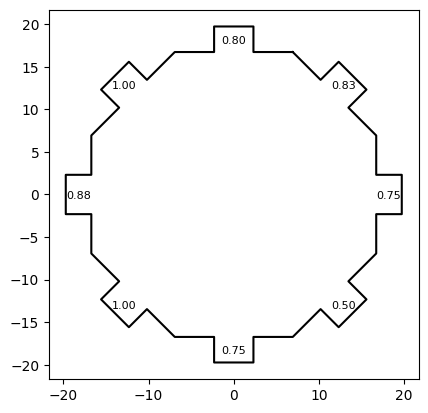

In [706]:
# Plot the octagon (you can use your existing function for this)
ax = plot_octagon.plot_octagon()

# Define ratios list
ratios_list = ratios_list

# Plot the ratios under the alcoves
ax = plot_ratios_under_alcoves(ax, ratios_list)

plt.show()


(2, 8)


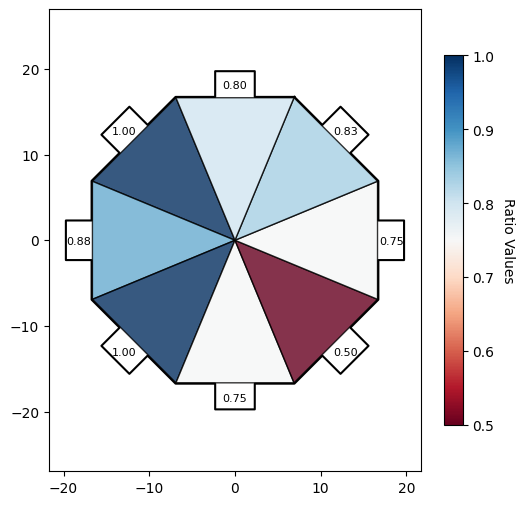

[0.8, 0.8333333333333334, 0.75, 0.5, 0.75, 1.0, 0.875, 1.0]


In [707]:
#plot color gradient octagon with ratios list (without subtracting average p(H))

fig, ax = plt.subplots(figsize=(6, 6))

#plot octagon
ax = plot_octagon.plot_octagon(ax=ax)

#define bin ranges
bin_ranges = bin_ranges


#define ratios list
ratios_list = ratios_list
ratios_list_reversed = ratios_list[::-1]

#color the segments of the octagon
ax = plot_colored_octagon(ax, bin_ranges, ratios_list)

#plot the ratios under the alcoves
ax = plot_ratios_under_alcoves(ax, ratios_list)

#add a colorbar for reference
sm = plt.cm.ScalarMappable(cmap=cm.RdBu, norm=plt.Normalize(vmin=min(ratios_list), vmax=max(ratios_list)))
sm.set_array([])  # Only necessary for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label("Ratio Values", rotation=270, labelpad=15)

plt.axis('equal')
plt.show()
print(ratios_list)

In [716]:
#calculate average p(H) regardless of bin

from collections import defaultdict

#initialize counters for the total high wall choices and total trials overall
true_counts = 0
total_counts = 0

#bin assignments and high wall chosen for all trial lists
trial_data = [(bin_assignments0, high_wall_chosen0), 
              (bin_assignments1, high_wall_chosen1)]


#iterate through all provided trial lists
for bin_assignments, high_wall_chosen in trial_data:

    #iterate over both lists simultaneously for the current trial list
    for is_high_wall_chosen in high_wall_chosen:
        total_counts += 1  #increment total trial count for the bin
        
        if is_high_wall_chosen:          #increment True count if high wall is chosen
            true_counts += 1

#calculate the average ratio 
print(true_counts)
print(total_counts)
overall_ratio = true_counts / total_counts

print(overall_ratio)


29
35
0.8285714285714286


In [718]:
#obtain difference between p(H) given bin and average p(H)

new_ratios_list = [ratio - overall_ratio for ratio in ratios_list]
print(new_ratios_list)

[-0.02857142857142858, 0.004761904761904745, -0.07857142857142863, -0.3285714285714286, -0.07857142857142863, 0.17142857142857137, 0.046428571428571375, 0.17142857142857137]


(2, 8)


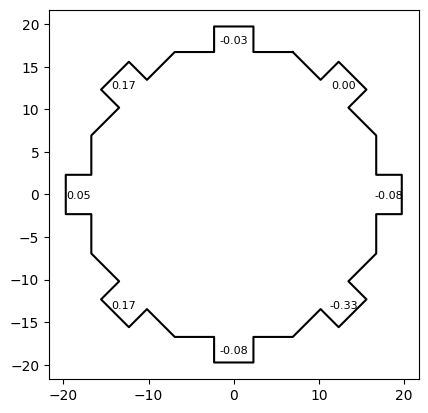

In [719]:
#plot octagon with new ratios list 
ax = plot_octagon.plot_octagon()

#define ratios list
new_ratios_list = new_ratios_list

#plot the ratios under the alcoves
ax = plot_ratios_under_alcoves(ax, new_ratios_list)

plt.show()


(2, 8)


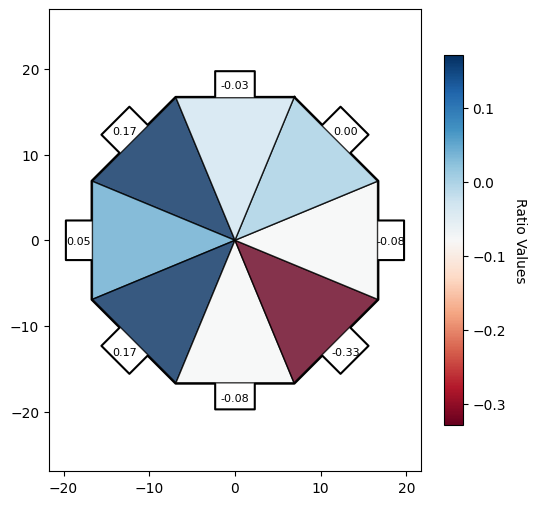

[-0.02857142857142858, 0.004761904761904745, -0.07857142857142863, -0.3285714285714286, -0.07857142857142863, 0.17142857142857137, 0.046428571428571375, 0.17142857142857137]


In [720]:
#plot color gradient octagon for new ratios list

fig, ax = plt.subplots(figsize=(6, 6))

#plot octagon
ax = plot_octagon.plot_octagon(ax=ax)

#define bin_ranges
bin_ranges = bin_ranges


#define ratios list
new_ratios_list = new_ratios_list
ratios_list_reversed = new_ratios_list[::-1]

#color the segments of the octagon
ax = plot_colored_octagon(ax, bin_ranges, new_ratios_list)

#plot the ratios under the alcoves
ax = plot_ratios_under_alcoves(ax, new_ratios_list)

#add a colorbar for reference
sm = plt.cm.ScalarMappable(cmap=cm.RdBu, norm=plt.Normalize(vmin=min(new_ratios_list), vmax=max(new_ratios_list)))
sm.set_array([])  # Only necessary for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label("Ratio Values", rotation=270, labelpad=15)

plt.axis('equal')
plt.show()
print(new_ratios_list)